# Part 3: Deep Learning Model

## Step 1: Install necessary modules

### Install pytorch package, this may take several minutes, please be patient

In [3]:
conda install -c pytorch pytorch

Solving environment: done

## Package Plan ##

  environment location: /Users/loni/opt/anaconda3

  added / updated specs:
    - pytorch


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pytorch-1.7.0              |          py3.7_0        63.4 MB  pytorch
    ------------------------------------------------------------
                                           Total:        63.4 MB

The following NEW packages will be INSTALLED:

  libuv              pkgs/main/osx-64::libuv-1.40.0-haf1e3a3_0
  typing_extensions  pkgs/main/noarch::typing_extensions-3.7.4.3-py_0

The following packages will be UPDATED:

  pytorch            pkgs/main::pytorch-1.6.0-cpu_py37hd70~ --> pytorch::pytorch-1.7.0-py3.7_0



pytorch-1.7.0        | 63.4 MB   | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to rest

### Install other packages

In [2]:
pip install Pillow torchvision matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [337]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


## Step 2: Import modules

In [258]:
import os, sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

## Step 3: Image Pre-processing

#### Images in a dataset do not usually have the same pixel intensity and dimensions. In this section, you will pre-process the dataset by standardizing the pixel values. The next required process is transforming raw images into tensors so that the algorithm can process them.

### 3.1 Import data

In [304]:
# The data file was created in the data clearning part
labels = pd.read_csv('score.csv')
labels

,imageDir,score
0,flowers/images/0.jpg,0.363636
1,flowers/images/1.jpg,0.227273
2,flowers/images/10.jpg,0.431818
3,flowers/images/100.jpg,0.477273
4,flowers/images/101.jpg,0.454545
...,...,...
1146,paints/images/95.jpg,0.363636
1147,paints/images/96.jpg,0.500000
1148,paints/images/97.jpg,0.568182
1149,paints/images/98.jpg,0.613636


In [305]:
# define 5 level of likeness
def likeScore(score):
    # very like
    if score >= 0.8:
        likeness = 4
    # like
    elif score >= 0.6:
        likeness = 3
    # midium
    elif score >= 0.4:
        likeness = 2
    # dislike
    elif score >= 0.2:
        likeness = 1
    # very dislike
    else:
        likeness = 0
        
    return likeness

# replace score to likeness
labels.score = labels.score.map(likeScore)

In [313]:
labels

,imageDir,score
0,flowers/images/0.jpg,1
1,flowers/images/1.jpg,1
2,flowers/images/10.jpg,2
3,flowers/images/100.jpg,2
4,flowers/images/101.jpg,2
...,...,...
1146,paints/images/95.jpg,1
1147,paints/images/96.jpg,2
1148,paints/images/97.jpg,2
1149,paints/images/98.jpg,3


### 3.2 Resize images to 100 X 100 

#### (not apply the module in torchvision, because the original image sizes of three different categories are different)

In [ ]:
# The function create a folder for resized images.
def imageResize(categoryList):
    
    for category in categoryList:
        path = category + '/images/'
    
        # create a new folder for resized images
        newpath = category + '/images_resized/'
        os.makedirs(newpath)
        dirs = os.listdir(path)

        for item in dirs:
            if os.path.isfile(path+item):
                im = Image.open(path+item)
                f, e = os.path.splitext(item)
                imResize = im.resize((100,100), Image.ANTIALIAS)
                imResize.save(newpath + '/' + f + '.jpg', 'JPEG', quality=90)
                
# Only execute the first time 
imageResize(['flowers', 'houses', 'paints'])

# Update the image dir. in the dataframe, only
labels['imageDir'] = labels['imageDir'].str.replace('images', 'images_resized')
labels

In [314]:
# Update the image dir. in the dataframe, only
labels['imageDir'] = labels['imageDir'].str.replace('images', 'images_resized')
labels

,imageDir,score
0,flowers/images_resized/0.jpg,1
1,flowers/images_resized/1.jpg,1
2,flowers/images_resized/10.jpg,2
3,flowers/images_resized/100.jpg,2
4,flowers/images_resized/101.jpg,2
...,...,...
1146,paints/images_resized/95.jpg,1
1147,paints/images_resized/96.jpg,2
1148,paints/images_resized/97.jpg,2
1149,paints/images_resized/98.jpg,3


### 3.2 Image standardization

#### Before normalization, let's take a look at what the original tricolor matrix of an 100 x 100 image looks like

In [53]:
# Input: image file
# Output: 3 dimensional array (tricolour, pixel_rawIndex, pixel_colIndex)
def jpg_2_arr(file):
    img=Image.open(file)
    r,g,b=img.split()

    r_arr=np.array(r).reshape(100*100)
    g_arr=np.array(g).reshape(100*100)
    b_arr=np.array(b).reshape(100*100)

    img_arr=np.concatenate((r_arr,g_arr,b_arr))
    result=img_arr.reshape((3,100,100))
    return result

# Exp. image
jpg_2_arr('flowers/images_resized/0.jpg')

array([[[30, 27, 21, ..., 16, 18, 21],
        [27, 27, 24, ..., 18, 19, 21],
        [25, 29, 29, ..., 20, 21, 22],
        ...,
        [18, 17, 21, ..., 19, 19, 21],
        [17, 18, 22, ..., 19, 19, 21],
        [15, 18, 21, ..., 19, 20, 21]],

       [[33, 30, 22, ..., 30, 32, 35],
        [30, 30, 25, ..., 32, 33, 35],
        [28, 32, 30, ..., 34, 35, 36],
        ...,
        [21, 20, 24, ..., 33, 35, 37],
        [20, 21, 25, ..., 35, 35, 37],
        [18, 21, 24, ..., 35, 36, 40]],

       [[26, 23, 16, ..., 13, 15, 18],
        [23, 23, 19, ..., 15, 16, 18],
        [21, 25, 24, ..., 17, 18, 19],
        ...,
        [10,  9, 13, ...,  7,  8, 10],
        [ 9, 10, 14, ...,  8,  8, 10],
        [ 7, 10, 13, ...,  8,  9, 12]]], dtype=uint8)

In [307]:
# image normalization for better efficiency on the following propagation function 
# Declare image normalization for latter usage
    
# Here is ImageNet statistics
means = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(means,std)])

test_transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(means,std)])

valid_transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(means,std)])

#### Here is an example of image matrix data after normalization

In [282]:
x = Image.open('flowers/images_resized/0.jpg')
train_transform(x)

tensor([[[-1.6042, -1.6555, -1.7583,  ..., -1.8439, -1.8097, -1.7583],
         [-1.6555, -1.6555, -1.7069,  ..., -1.8097, -1.7925, -1.7583],
         [-1.6898, -1.6213, -1.6213,  ..., -1.7754, -1.7583, -1.7412],
         ...,
         [-1.8097, -1.8268, -1.7583,  ..., -1.7925, -1.7925, -1.7583],
         [-1.8268, -1.8097, -1.7412,  ..., -1.7925, -1.7925, -1.7583],
         [-1.8610, -1.8097, -1.7583,  ..., -1.7925, -1.7754, -1.7583]],

        [[-1.4580, -1.5105, -1.6506,  ..., -1.5105, -1.4755, -1.4230],
         [-1.5105, -1.5105, -1.5980,  ..., -1.4755, -1.4580, -1.4230],
         [-1.5455, -1.4755, -1.5105,  ..., -1.4405, -1.4230, -1.4055],
         ...,
         [-1.6681, -1.6856, -1.6155,  ..., -1.4580, -1.4230, -1.3880],
         [-1.6856, -1.6681, -1.5980,  ..., -1.4230, -1.4230, -1.3880],
         [-1.7206, -1.6681, -1.6155,  ..., -1.4230, -1.4055, -1.3354]],

        [[-1.3513, -1.4036, -1.5256,  ..., -1.5779, -1.5430, -1.4907],
         [-1.4036, -1.4036, -1.4733,  ..., -1

### 3.3 Split dataset

In [315]:
# The 'train_test_split' package are from Sklearns, which is a popular tool in machine learning fields
# Here the train-test data size ratio is 4:1 
train_data, test_data = train_test_split(labels, test_size=0.2)

# Validation dataset will be split from the traning dataset
train_data, valid_data = train_test_split(train_data, test_size=0.1)

In [192]:
train_data

,imageDir,score
71,flowers/images_resized/162.jpg,0.659091
210,flowers/images_resized/288.jpg,0.727273
564,houses/images_resized/259.jpg,0.295455
307,flowers/images_resized/375.jpg,0.386364
34,flowers/images_resized/129.jpg,0.227273
...,...,...
1061,paints/images_resized/388.jpg,0.590909
211,flowers/images_resized/289.jpg,0.500000
865,paints/images_resized/210.jpg,0.363636
199,flowers/images_resized/278.jpg,0.704545


In [193]:
test_data

,imageDir,score
312,flowers/images_resized/38.jpg,0.636364
283,flowers/images_resized/353.jpg,0.522727
804,paints/images_resized/156.jpg,0.340909
608,houses/images_resized/30.jpg,0.590909
996,paints/images_resized/329.jpg,0.681818
...,...,...
289,flowers/images_resized/359.jpg,0.613636
754,paints/images_resized/110.jpg,0.272727
1031,paints/images_resized/360.jpg,0.363636
1001,paints/images_resized/333.jpg,0.454545


In [316]:
valid_data

,imageDir,score
360,flowers/images_resized/63.jpg,2
198,flowers/images_resized/277.jpg,3
1089,paints/images_resized/43.jpg,1
582,houses/images_resized/276.jpg,3
492,houses/images_resized/190.jpg,1
...,...,...
204,flowers/images_resized/282.jpg,3
546,houses/images_resized/241.jpg,1
558,houses/images_resized/253.jpg,2
531,houses/images_resized/228.jpg,3


### 3.4 Pre-process data for loaders 

In [284]:
# Declare a class for dataset format
# input is the image score dataframe
# output is the formatted image dataset and its score labels
class formatDataset(Dataset):
    def __init__(self, data, path , transform = None):
        super().__init__()
        self.data = data
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_path,label = self.data[index]
        image = Image.open(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [317]:
# Place file in the working directory
train_path = r'/train/'
test_path = r'/test/'

train_data = formatDataset(train_data.values, train_path, train_transform)
valid_data = formatDataset(valid_data.values, train_path, valid_transform)
test_data = formatDataset(test_data.values, test_path, test_transform)

### 3.5 Load dataset

In [318]:
train_loader = DataLoader(dataset = train_data, batch_size = 4, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset = valid_data, batch_size = 4, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset = test_data, batch_size = 4, shuffle=False, num_workers=0)

In [287]:
# Use torch.device function to set GPU for parallel computation if there is an available GPU
# If not, the program will use CPU by default
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Step 4: Construct Convolution Neural Network (CNN)

### 4.1 Set hyper-parameters

In [331]:
num_epochs = 50
num_classes = 2
batch_size = 4
learning_rate = 0.001

### 4.2 Build and assemble forward propogation layers 

### There will be 3 main layers in the network:

#### 1) Convolution layer for feature abstraction
#### 2) Pooling layer for removal of positional feature effects
#### 3) Activation layer for non-linearity transformation
#### Usually, there are more than one layers for each types of layers

In [311]:
# Declare Convolution neural Network for forward propagation
class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(180, 1024)
        self.fc2 = nn.Linear(1024, 5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 5))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 5))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [290]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=180, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=5, bias=True)
)


## Step 5: Loss function and optimizer

#### The most common cross-entropy loss is used in this project, which can be formulated as: 
#### logloss(N=1) = ylog(p) + (1 - y)log(1 - p)

In [291]:
# declare loss function and optimizer
criterion = nn.CrossEntropyLoss()

#### Here, the adaptive moment estimation (Adam) is applied as optimizer

In [292]:
model = CNN().to(device) # make sure the device option was run in previous step
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

## Step 6: Train and optimize

In [332]:
# keeping-track-of-losses 
train_losses = []
valid_losses = []

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device, dtype=torch.int64)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

Epoch: 1 	Training Loss: 0.981811 	Validation Loss: 1.280269
Epoch: 2 	Training Loss: 0.992623 	Validation Loss: 1.273741
Epoch: 3 	Training Loss: 0.959942 	Validation Loss: 1.280848
Epoch: 4 	Training Loss: 0.952684 	Validation Loss: 1.281827
Epoch: 5 	Training Loss: 0.967177 	Validation Loss: 1.282847
Epoch: 6 	Training Loss: 0.954350 	Validation Loss: 1.290775
Epoch: 7 	Training Loss: 0.946522 	Validation Loss: 1.292814
Epoch: 8 	Training Loss: 0.972833 	Validation Loss: 1.293446
Epoch: 9 	Training Loss: 0.944201 	Validation Loss: 1.304687
Epoch: 10 	Training Loss: 0.930092 	Validation Loss: 1.312343
Epoch: 11 	Training Loss: 0.940723 	Validation Loss: 1.319807
Epoch: 12 	Training Loss: 0.918080 	Validation Loss: 1.311483
Epoch: 13 	Training Loss: 0.907122 	Validation Loss: 1.323493
Epoch: 14 	Training Loss: 0.908888 	Validation Loss: 1.324066
Epoch: 15 	Training Loss: 0.927303 	Validation Loss: 1.341262
Epoch: 16 	Training Loss: 0.896654 	Validation Loss: 1.337131
Epoch: 17 	Traini

## Step 7: Test and predict

In [336]:
# test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device,  dtype=torch.int64)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

# Save 
#torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model: 38.52813852813853 %


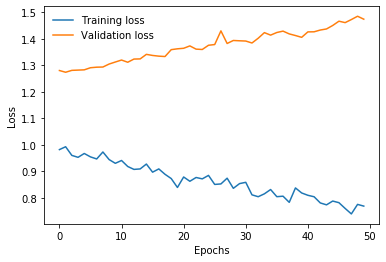

In [334]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)